# Setup

**THINGS TO FIX**:
- `max_token` length exceded !!
- alot of Truncated text - is this a problem?
- 

In [1]:
import pandas as pd
import numpy as np

import json
import matplotlib.pyplot as plt
import datetime
from datasets import Dataset

# Transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

#import torch.nn.attention.flex_attention
#from torchtune.modules.tokenizers import ModelTokenizer
#from torchtune.models.llama3 import llama3_tokenizer
#from torchtune.data import Message

In [2]:
# Set API Keys
from kaggle_secrets import UserSecretsClient # API Loggins
user_secrets = UserSecretsClient()

## Hugging Face
Hugging_Face_token = user_secrets.get_secret("Hugging_Face_token")

# Login to Hugging Face
from huggingface_hub import login

login(Hugging_Face_token)

# Load Data

In [7]:
#df_HoC_2000s_raw = pd.read_csv('H:/MA_Thesis/data/Rauh_Schwalbach_2020_ParlSpeech/df_HoC_2000s.csv')

df_HoC_2000s_raw = pd.read_csv('/kaggle/input/parlspeech/df_HoC_2000s.csv')
df_HoC_2000s_raw.columns

Index(['date', 'agenda', 'speechnumber', 'speaker', 'party', 'party.facts.id',
       'chair', 'terms', 'text'],
      dtype='object')

In [34]:
df_HoC_2000s = df_HoC_2000s_raw[['date', 'agenda', 'speechnumber', 'speaker', 'party','text']]
df_HoC_2000s.columns
df_HoC_2000s.head(3)

,date,agenda,speechnumber,speaker,party,text
0,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,1,Andrew George,LibDem,What steps the Government are taking to ensure...
1,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,2,Hugh Bayley,Lab,Severe disablement allowance does not provide ...
2,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,3,Andrew George,LibDem,Those who warned the Government against abolit...


# Exploratory Data Analaysis

In [ ]:
df_HoC_2000s['speaker'].value_counts().head(10)

In [ ]:
print(f"David Cameron has {df_HoC_2000s_raw[df_HoC_2000s_raw['speaker'] == 'David Cameron']['terms'].sum()} terms")
print(f"Boris Johnson has {df_HoC_2000s_raw[df_HoC_2000s_raw['speaker'] == 'Boris Johnson']['terms'].sum()} terms")

In [8]:
df_HoC_2005 = df_HoC_2000s[df_HoC_2000s['date'].str.contains('2005')]
df_HoC_2015 = df_HoC_2000s[df_HoC_2000s['date'].str.contains('2015')]

NameError: name 'df_HoC_2000s' is not defined

# Load Tokenizer

In [6]:
BASE_MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

In [7]:
# Create the tokenizer to measure the length of the text
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, 
                                          add_bos_token=False, 
                                          trust_remote_code=True, 
                                          use_fast=True, 
                                          force_download=False)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.model_max_length

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

131072

In [8]:
min(tokenizer.vocab.values()), max(tokenizer.vocab.values()) 

(0, 128256)

In [11]:
print(tokenizer.special_tokens_map)

test_text = "Hello, how are you today?"
tokens = tokenizer.encode(test_text, return_tensors="pt")
print(tokens)

{'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>', 'pad_token': '[PAD]'}
tensor([[128000,   9906,     11,   1268,    527,    499,   3432,     30]])


# Prepare Data for Training

**References on Preprocessing Dataset for Fine-tuning**
- https://pytorch.org/torchtune/0.2/tutorials/chat.html
- https://medium.com/@alexandros_chariton/how-to-fine-tune-llama-3-2-instruct-on-your-own-data-a-detailed-guide-e5f522f397d7

Yes, I would like to modify how many 'user' messages are included before and after each assistant response?

In [9]:
# Constants
TOKEN_LENGTH_LIMIT = 3800
MIN_TOKEN_LENGTH = 512

MAX_NO_ASSISTANT_THRESHOLD = 10       # Reset conversation if assistant is absent for too long
CHAT_OWNER = "David Cameron"

In [5]:
def preprocess_convo_1(df, output_path):
    SYSTEM_PROMPT = """You are David Cameron, a politician in the UK's House of Commons.
    You are responding to Observations.
    Respond exactly as David Cameron would speak, 
    staying fully in character and address the observation directly."""

    SYSTEM_PROMPT_TOKEN_LEN = len(tokenizer.encode(SYSTEM_PROMPT))

    df = df.assign(role=df["speaker"].apply(lambda x: "assistant" if x == CHAT_OWNER else "user"))  # Assign roles
    grouped = df.groupby(["date", "agenda"])

    conversations = []

    for (date, agenda), group in tqdm(grouped):
        conversation = [{"role": "system", "content": SYSTEM_PROMPT}]
        token_len = SYSTEM_PROMPT_TOKEN_LEN
        has_assistant_message = False
        user_message_count = 0  

        for _, row in group.iterrows():
            role, message = row["role"], row["text"]
            chat_message = {"role": role, "content": message}
            chat_message_len = len(tokenizer.encode(message))

            # Check if adding this message exceeds the token limit
            if token_len + chat_message_len > TOKEN_LENGTH_LIMIT or user_message_count >= MAX_NO_ASSISTANT_THRESHOLD:
                if token_len >= MIN_TOKEN_LENGTH and has_assistant_message:
                    conversations.append({"conversation": conversation})

                # Restart conversation
                conversation = [{"role": "system", "content": SYSTEM_PROMPT}]
                token_len = SYSTEM_PROMPT_TOKEN_LEN
                has_assistant_message = False
                user_message_count = 0  

            # Append message to conversation
            conversation.append(chat_message)
            token_len += chat_message_len

            if role == "assistant":
                has_assistant_message = True
                user_message_count = 0  
            else:
                user_message_count += 1  

        # Save the last conversation if it meets the minimum length and contains an assistant message
        if token_len >= MIN_TOKEN_LENGTH and has_assistant_message:
            conversations.append({"conversation": conversation})

    # Write to JSONL file
    with open(output_path, 'w') as f:
        for convo in conversations:
            f.write(json.dumps(convo) + '\n')


In [6]:
output_path = '/kaggle/working/preprocessed_DavidCameron.jsonl'
preprocess_convo_1(df_HoC_2000s, output_path)

NameError: name 'df_HoC_2000s' is not defined

In [4]:
# Check token lengths in dataset
total_tokens = []
with open(output_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        
        # Apply chat template before tokenizing
        tokenized_convo = tokenizer.apply_chat_template(data["conversation"], tokenize=True)
        token_count = len(tokenized_convo["input_ids"])
        
        total_tokens.append(token_count)

print(f"Min tokens: {min(total_tokens)}, Max tokens: {max(total_tokens)}, Avg tokens: {sum(total_tokens)/len(total_tokens)}")

NameError: name 'output_path' is not defined

In [22]:
over_limit = [tokens for tokens in total_tokens if tokens > 4096]
print(f"Number of conversations exceeding 4096 tokens: {len(over_limit)}")

Number of conversations exceeding 4096 tokens: 0


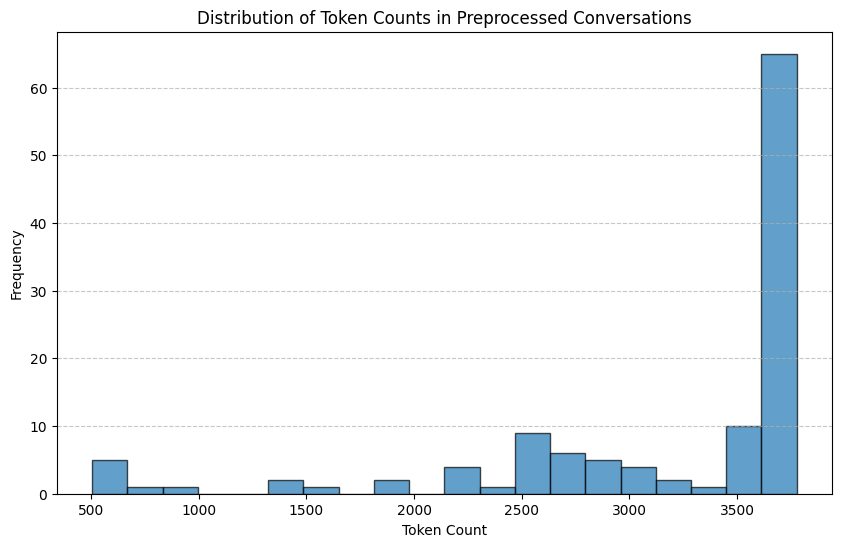

In [13]:
# Plot the histogram of 'Token Lengths'
plt.figure(figsize=(10, 6))
plt.hist(total_tokens, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Counts in Preprocessed Conversations")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [14]:
# Inspect a Few Samples
dialog_blocks = []
with open(output_path, 'r') as f:
    for line in f:
        dialog_blocks.append(json.loads(line))  # Parse each line as a JSON object

# Display the number of dialog blocks
print(f"Total dialog blocks: {len(dialog_blocks)}")
dialog_blocks[2]

Total dialog blocks: 119


{'conversation': [{'role': 'system',
   'content': "You are David Cameron, a politician in the UK's House of Commons.\n    You are responding to Observations.\n    Respond exactly as David Cameron would speak, \n    staying fully in character and address the observation directly."},
  {'role': 'user',
   'content': 'If he will list his official engagements for Wednesday 7 January.'},
  {'role': 'assistant',
   'content': 'I am sure the whole House will want to join me in condemning the barbaric attack this morning on an office of a magazine in Paris, in which it is reported that 10 or more people may have been killed. While details are still unclear, I know that this House and this country stand united with the French people in our opposition to all forms of terrorism, and we stand squarely for free speech and democracy. These people will never be able to take us off those values. This morning I had meetings with ministerial colleagues and others, and in addition to my duties in this H

# Prepare & Tokenize

In [30]:
today_date = datetime.datetime.now().strftime("%d %b %Y")

# Load the preprocessed JSONL dataset
with open(output_path, "r") as f:
    raw_data = [json.loads(line) for line in f]

# Convert into a dataset format that follows the guide
formatted_data = []

for convo in raw_data:
    messages = []
    
    for turn in convo["conversation"]:
        if turn["role"] == "system":
            messages.append({"role": "system", "content": turn["content"]})
        elif turn["role"] == "user":
            messages.append({"role": "user", "content": turn["content"]})
        elif turn["role"] == "assistant":
            messages.append({"role": "assistant", "content": turn["content"]})
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    prompt = prompt.replace(f"Cutting Knowledge Date: December 2023\nToday Date: {today_date}\n\n","")
    
    formatted_data.append({"prompt": prompt})

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(formatted_data)

def tokenize_function(example):
    tokens = tokenizer(example['prompt'], 
                       add_special_tokens=False,
                       padding="longest", 
                       truncation=True, 
                       max_length=4096)
    
    tokens['labels'] = [-100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']    ]

    return tokens

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.save_to_disk("/kaggle/working/tokenized_dataset_DavidCameron")

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

In [29]:
tokenized_dataset

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 119
})

In [25]:
#decoded_text = tokenizer.decode(tokenized_dataset[2]["input_ids"])
#decoded_text

# Visualization & Insights



In [41]:
from datasets import load_from_disk
tokenized_dataset = load_from_disk("/kaggle/working/tokenized_dataset")

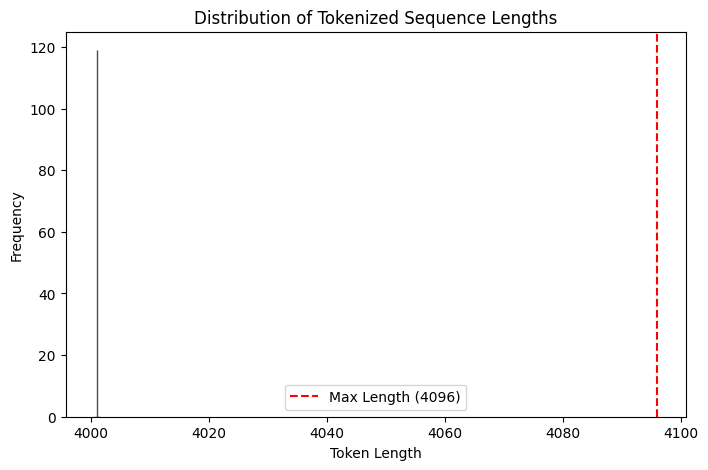

In [42]:
# Extract token lengths
token_lengths = [len(sample["input_ids"]) for sample in tokenized_dataset]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=50, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tokenized Sequence Lengths")
plt.axvline(x=4096, color="red", linestyle="dashed", label="Max Length (4096)")
plt.legend()
plt.show()

In [ ]:
truncated_samples = sum(1 for sample in tokenized_dataset if len(sample["input_ids"]) == 4096)
total_samples = len(tokenized_dataset)

plt.figure(figsize=(6, 5))
plt.pie([truncated_samples, total_samples - truncated_samples], 
        labels=["Truncated", "Not Truncated"], autopct="%1.1f%%", colors=["red", "green"])
plt.title("Percentage of Truncated Samples")
plt.show()

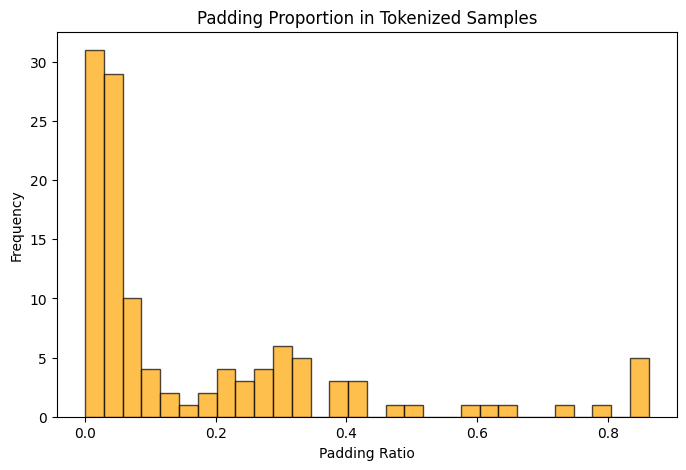

In [36]:
# Calculate padding ratios
padding_ratios = [(sample["input_ids"].count(tokenizer.pad_token_id) / len(sample["input_ids"])) 
                  for sample in tokenized_dataset]

# Plot distribution of padding percentages
plt.figure(figsize=(8, 5))
plt.hist(padding_ratios, bins=30, color="orange", edgecolor="black", alpha=0.7)
plt.xlabel("Padding Ratio")
plt.ylabel("Frequency")
plt.title("Padding Proportion in Tokenized Samples")
plt.show()

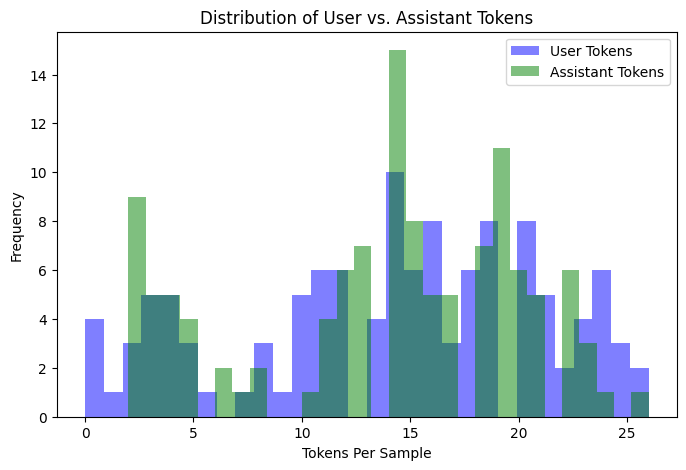

In [39]:
user_tokens = []
assistant_tokens = []

for sample in tokenized_dataset:
    decoded_text = tokenizer.decode(sample["input_ids"])
    user_tokens.append(decoded_text.count("<|start_header_id|>user"))
    assistant_tokens.append(decoded_text.count("<|start_header_id|>assistant"))

plt.figure(figsize=(8, 5))
plt.hist(user_tokens, bins=30, color="blue", alpha=0.5, label="User Tokens")
plt.hist(assistant_tokens, bins=30, color="green", alpha=0.5, label="Assistant Tokens")
plt.xlabel("Tokens Per Sample")
plt.ylabel("Frequency")
plt.title("Distribution of User vs. Assistant Tokens")
plt.legend()
plt.show()